# Simulated classification problem and toy dataset

In [2]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.special import binom 
from itertools import combinations
iris = datasets.load_iris()

In [14]:
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import tqdm

In [34]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'

In [23]:
import sys
sys.path.append('./shapley_compute/')
from shapley_compute.ensembled_mp import mp_shapley
from shapley_compute.minipatches import minipatch_regression_loo

In [13]:
X = iris['data']
y = iris['target']
feature_names = iris['feature_names']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [20]:
model = RandomForestClassifier()
model.fit(X_train, y_train)


RandomForestClassifier()

In [38]:
# model.predict_proba(X_test)

In [25]:
x_ratio = 0.1
B = 1000
res = minipatch_regression_loo(X, y, model, x_ratio, B)
_, _, in_mp_loo, _ = res
X_test = X[np.where(in_mp_loo == True)[1],:] 
shap_est = mp_shapley(X_test, res)

In [39]:
shap_values = explainer.shap_values(X_test)

NameError: name 'explainer' is not defined

<BarContainer object of 4 artists>

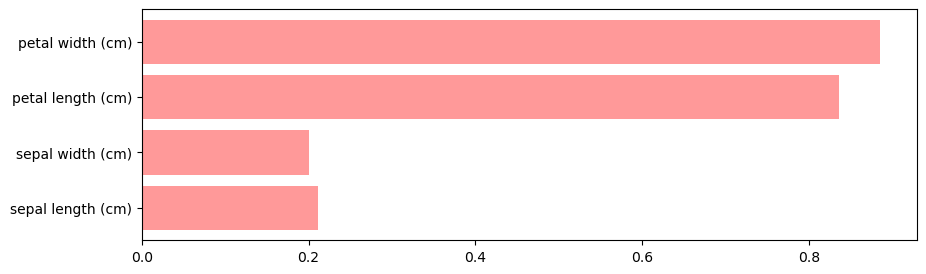

In [33]:
fig, ax = plt.subplots(figsize=(10,3))
ax.barh(feature_names, np.mean(np.abs(shap_est),axis=0), alpha=0.4, color='red')
# ax.barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(shap_values_lr.values),axis=0), alpha = 0.4, color='blue')

In [37]:
def waterfall_shap(*kwargs):
    fig = go.Figure(go.Waterfall(
    name = "Iris dataset", orientation = "h",#  measure = ["total"]+["relative" for i in range(len(y)-1)],
    y = feature_names,
    x = np.mean(shap_est,axis=0),
    connector = {"visible":False}
    ))
    
    fig.update_layout(title = "Feature importance for minipatch shapley on iris dataset")
    
    fig.show()

In [12]:

def minipatch_classification_loo(X_arr, y_arr, model, x_ratio, B=1000, plot_prop=False):
    """ Fit the minipatch ensemble estimator on the training data and predict on leave-one-out Xi
    Input:
        X_arr: training predictors
        y_arr: training set response
        Xi: test set
        model: chosen model for regression
        x_ratio: ratio of observation to sample from
        B: number of replicates
        plot_prop: if True, plots the minipatch feature coverage histogram
    -------
    Outputs: 
        [np.array, np.array, np.array]: prediction on test set, boolean dictionary of minipatch observations, boolean dictionary of minipatch features
    """
    pred = []
    mp_feat_size = []
    N = X_arr.shape[0]
    M = X_arr.shape[1]
    in_mp_obs, in_mp_loo, in_mp_feature = np.zeros((B,N),dtype=bool), np.zeros((B,N),dtype=bool), np.zeros((B,M),dtype=bool)
    for b in range(B):  
        x_mp, y_mp, idx_I, idx_F = get_minipatch(X_arr, y_arr, x_ratio)
        mp_feat_size.append(len(idx_F))
        model.fit(x_mp[:-1,:], y_mp[:-1]) # leave-one-out
        Xi = x_mp[-1,:]
        pred.append(pd.DataFrame(model.predict_proba(Xi.reshape(1,-1)))) # use predict proba? 
        
        in_mp_obs[b,idx_I[:-1]] = True # minipatch b train points
        in_mp_feature[b,idx_F] = True
        in_mp_loo[b, idx_I[-1]] = True # test point loo
    if plot_prop:
        plt.hist(mp_feat_size)
        plt.suptitle('Minipatch length histogram')
    
    return [np.array(pred),in_mp_obs,in_mp_loo, in_mp_feature]